In [1]:
import numpy as np
import scipy.sparse as sp

def jacobi(A, b, tol, max_iter):
    """Resuelve A x = b por el método de Jacobi."""
    x = np.zeros_like(b)
    D = sp.diags(A.diagonal())  # Extraemos la diagonal de A
    K = A - D  # K = L + U
    errores = []
    for k in range(max_iter):
        x_nuevo = (b - K @ x) / D.diagonal()
        error = np.linalg.norm(x_nuevo - x, ord=np.inf)
        errores.append(error)
        if error < tol:
            print(f"Convergencia en {k} iteraciones (Jacobi).")
            return x_nuevo, errores
        x = x_nuevo
    print("No hubo convergencia (Jacobi).")
    return x, errores

In [2]:
def set_A_b(N):
    """
    Construye la matriz A y el vector b para la ecuación de Laplace en 2D.

    Parámetros:
    - N: número de nodos interiores en cada dimensión (sin contar los bordes).

    Retorna:
    - A: matriz dispersa rala del sistema.
    - b: vector independiente.
    """
    # Tamaño del paso
    h = 1 / (N + 1)
    
    # Número total de nodos interiores
    num_nodes = N * N

    # Coeficientes para las diagonales de la matriz A
    main_diag = 4 * np.ones(num_nodes)  # Diagonal principal
    side_diag = -1 * np.ones(num_nodes - 1)  # Vecinos en la misma fila
    up_down_diag = -1 * np.ones(num_nodes - N)  # Vecinos en filas adyacentes

    # Ajustar la diagonal secundaria (side_diag) para evitar conexiones entre filas
    for i in range(1, N):
        side_diag[i * N - 1] = 0

    # Construcción de A usando scipy.sparse.diags
    A = sp.diags([main_diag, side_diag, side_diag, up_down_diag, up_down_diag],
        [0, -1, 1, -N, N], format="csc")

    # Construcción del vector b
    b = np.zeros(num_nodes)

    # Condiciones de borde no nulas
    for j in range(N):  # Filas (y)
        for i in range(N):  # Columnas (x)
            idx = j * N + i
            # Borde izquierdo (x = 0): u(0, y) = 1
            if i == 0:
                b[idx] += 1
            # Borde inferior (y = 0): u(x, 0) = 1
            if j == 0:
                b[idx] += 1
    return A, b

In [3]:
# Configuración del problema
N = 50  # Cantidad de puntos de la malla N x N
tol = 1.0e-6  # Tolerancia para la convergencia
max_iter = 10000  # Máximos número de iteraciones

A, b = set_A_b(N)
print(f"Elementos no nulos de A: {A.nnz}, {A.nnz / (N ** 2)} % del total.")

# Solución por el método de Jacobi
x_sol_jacobi, errores_jacobi = jacobi(A, b, tol=tol, max_iter=max_iter)
x_sol_jacobi[:4]

Elementos no nulos de A: 12300, 4.92 % del total.
Convergencia en 3865 iteraciones (Jacobi).


array([0.99915622, 0.99831244, 0.99746866, 0.99662484])

In [4]:
import scipy.sparse.linalg as spla

def gauss_seidel(A, b, tol=1e-6, max_iter=1000):
    """Resuelve A x = b por el método de Gauss-Seidel."""
    n = len(b)
    x = np.zeros(n)  # Solución inicial
    errores = []
    
    # Extraemos L, D y U de A
    D = sp.diags(A.diagonal(), format='csc')  # Matriz diagonal
    L = sp.tril(A, k=-1, format='csc')        # Parte estrictamente inferior
    U = sp.triu(A, k=1, format='csc')         # Parte estrictamente superior

    # Descomposición: (L + D)^(-1)
    LD_inv = spla.inv(L + D)

    for k in range(max_iter):
        # Actualización vectorizada
        x_new = LD_inv @ (b - U @ x)
        error = np.linalg.norm(x_new - x, ord=np.inf)
        errores.append(error)
        # Comprobar convergencia
        if error < tol:
            print(f"Convergencia en {k + 1} iteraciones (Gauss-Seidel)")
            return x_new, errores

        x = x_new

    print("No convergió (Gauss-Seidel)")
    return x, errores

In [5]:
# Solución por el método de Gauss-Seidel
x_sol_gs, errores_gs = gauss_seidel(A, b, tol=tol, max_iter=max_iter)
x_sol_gs[:4]

Convergencia en 2105 iteraciones (Gauss-Seidel)


array([0.99915712, 0.99831425, 0.99747138, 0.99662845])

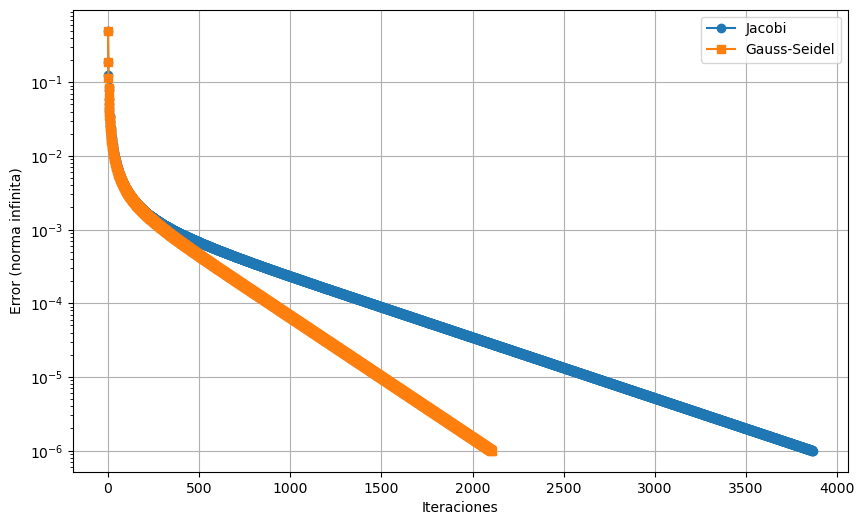

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogy(errores_jacobi, label='Jacobi', marker='o')
plt.semilogy(errores_gs, label='Gauss-Seidel', marker='s')
plt.xlabel('Iteraciones')
plt.ylabel('Error (norma infinita)')
plt.legend()
plt.grid()
plt.show()

In [8]:
x_gmres, num_it = spla.gmres(A, b, rtol=tol)
if num_it:
    print(f"No hubo convergencia en {num_it} iteraciones.")
else:
    print(x_gmres[:4])

[0.99915818 0.99831629 0.99747435 0.99663237]



### Copyright 2020-2025 Facundo Batista y Manuel Carlevaro

Licencia CC BY-NC-SA 4.0

Para más info visitar: https://github.com/facundobatista/libro-pyciencia/

